# Анализ и загрузка данных

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from io import BytesIO
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

%matplotlib inline

In [27]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [3]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [4]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [5]:
df_ts.shape

(400, 2)

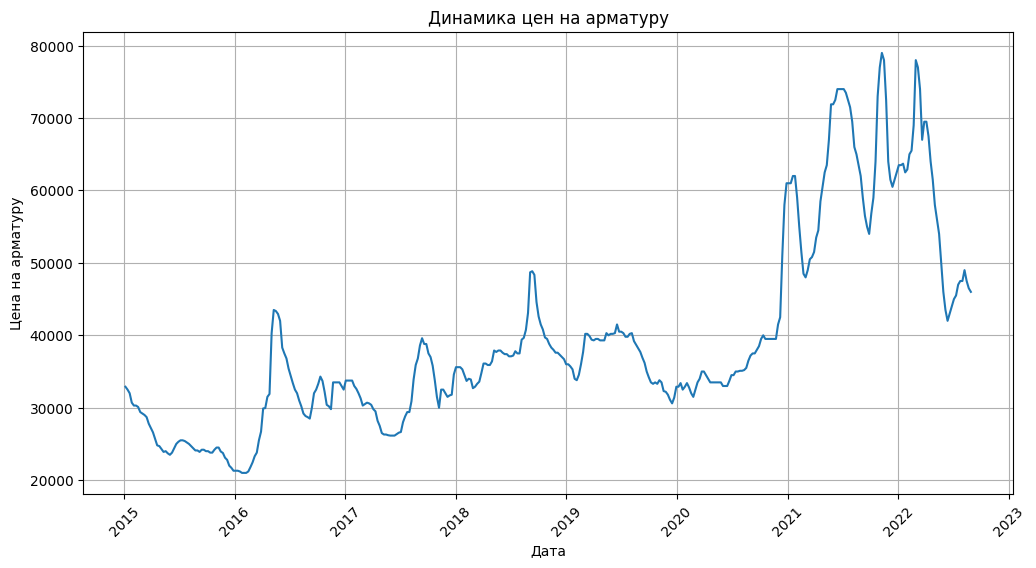

In [6]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["dt"], df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

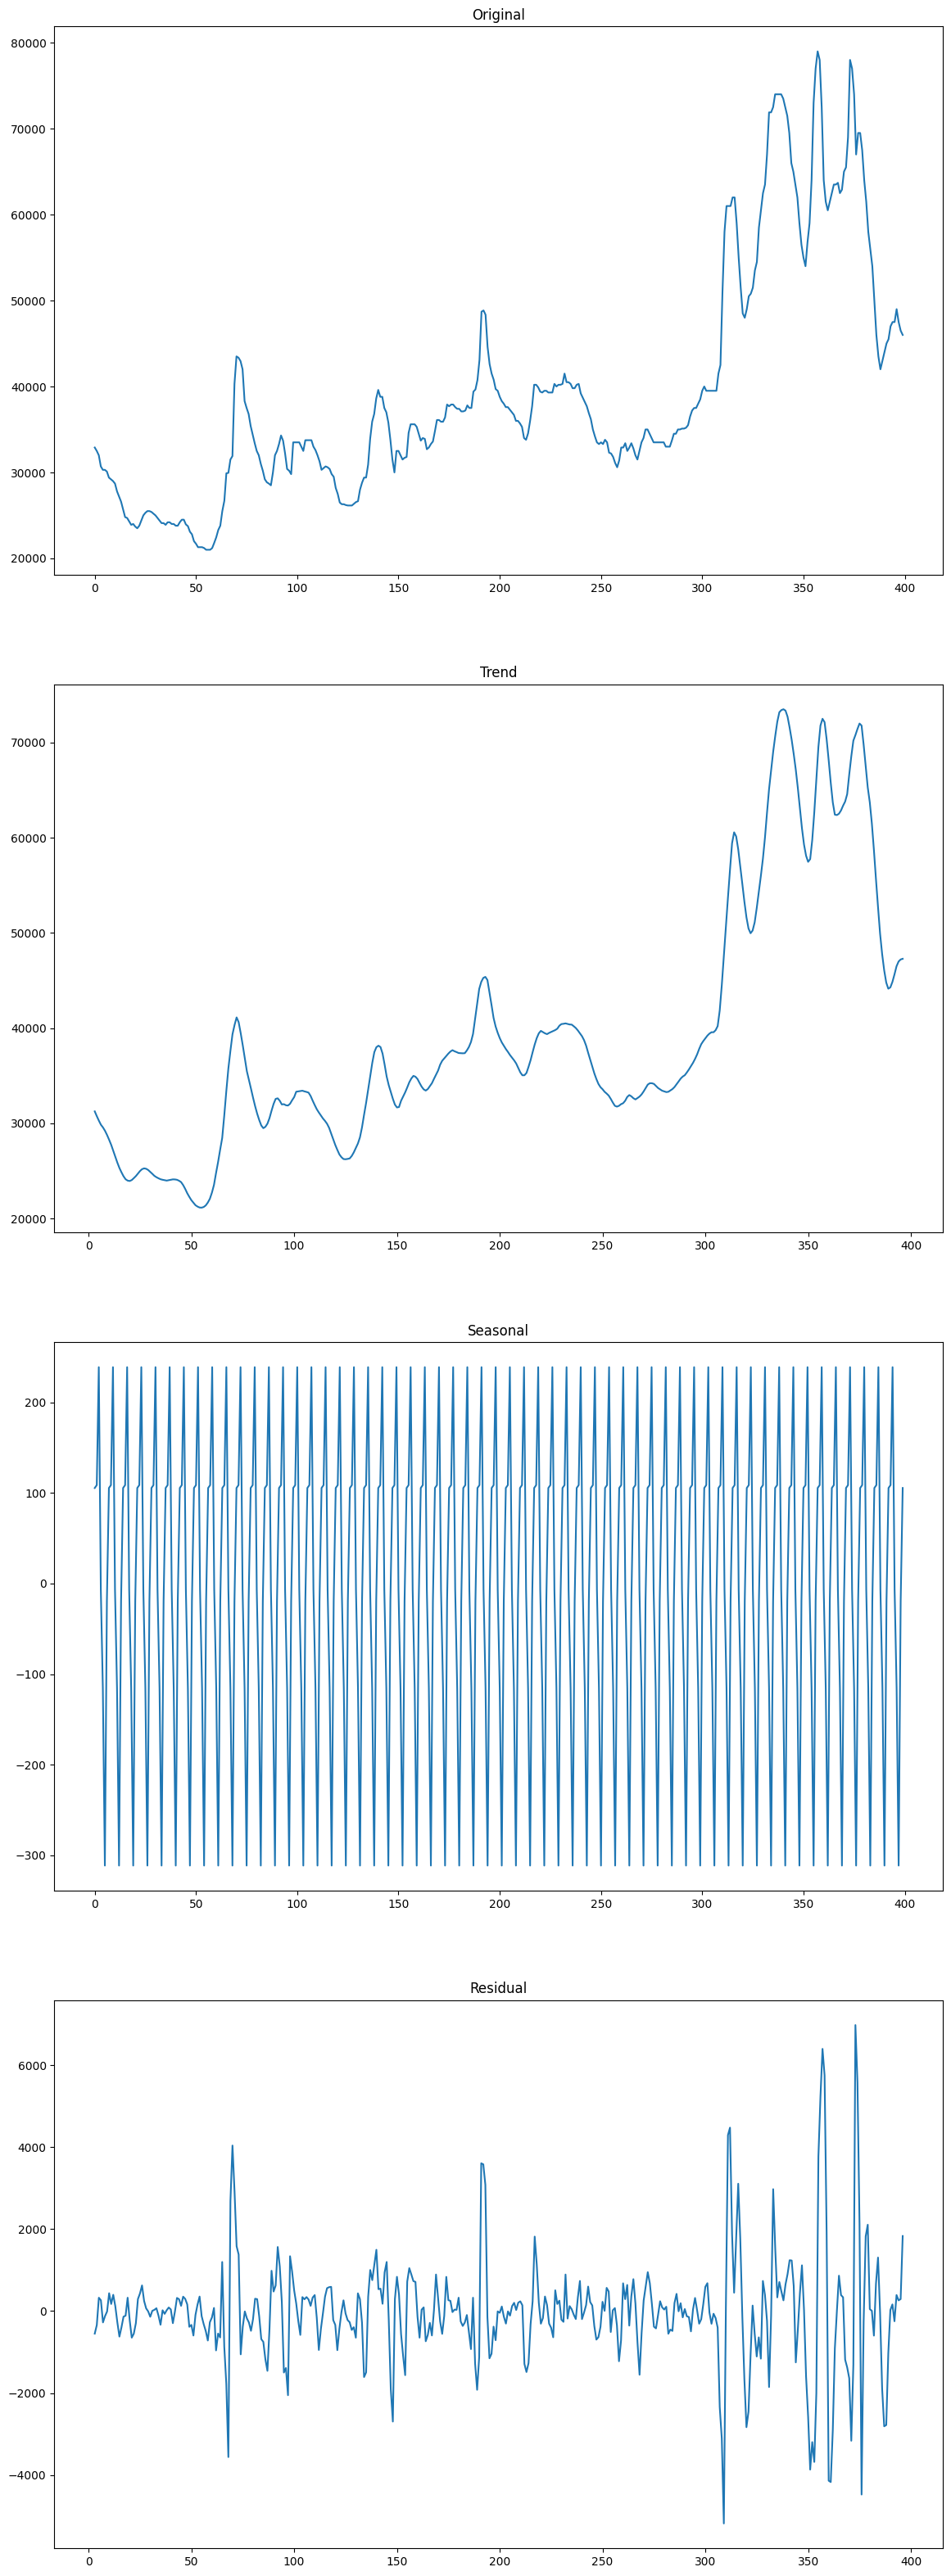

In [7]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 7)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [8]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 60, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023])

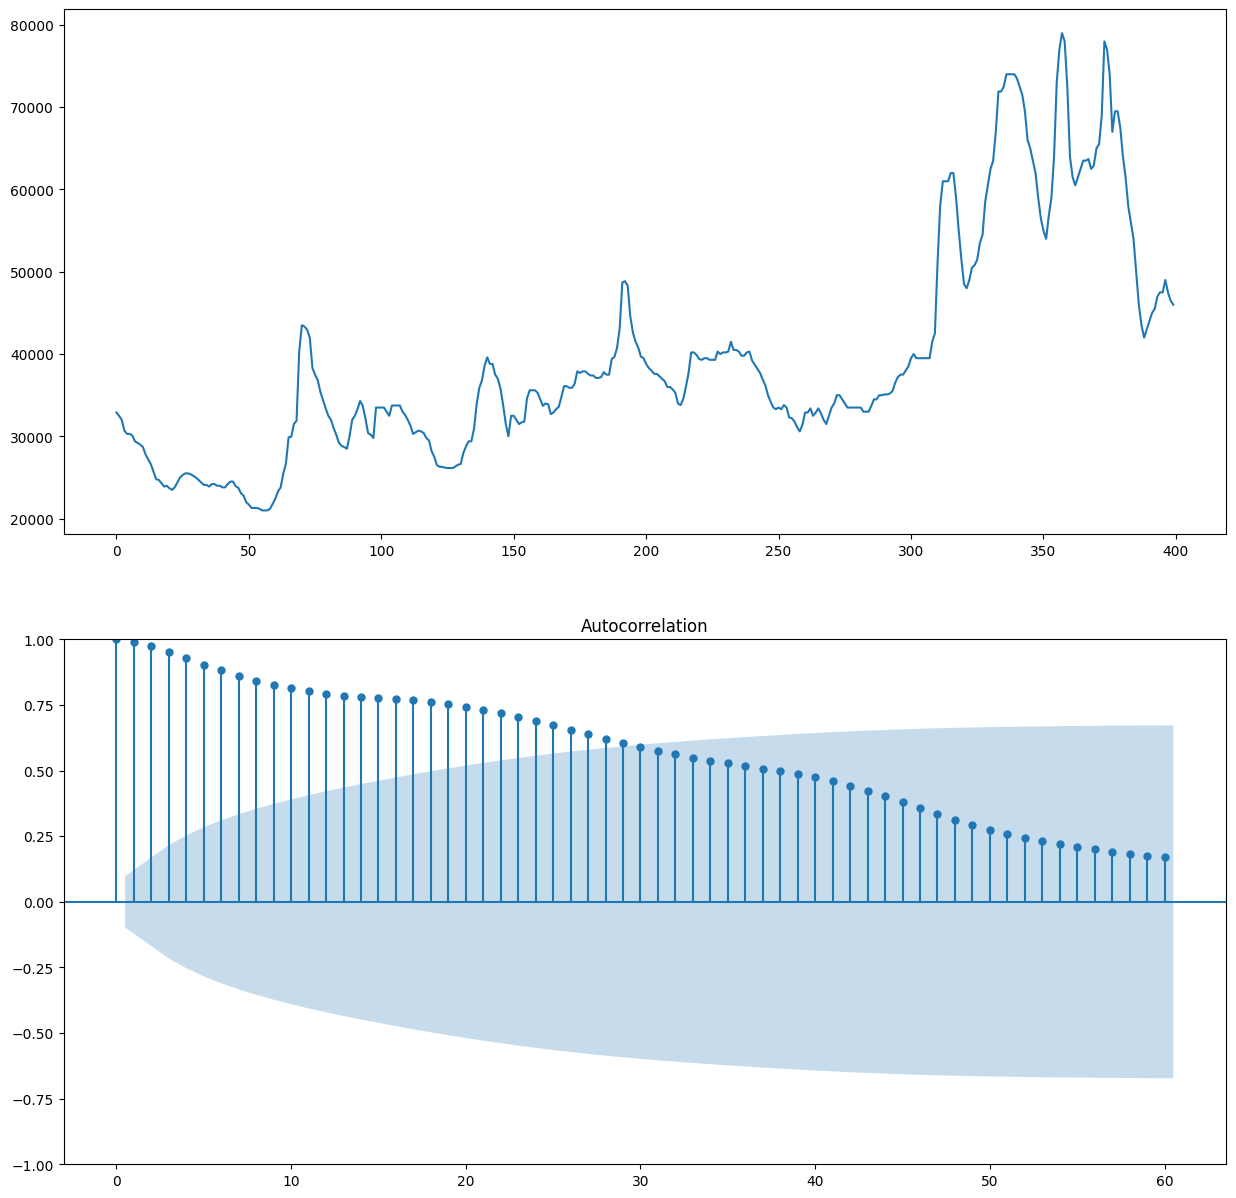

In [9]:
# Визуализация автокорреляции

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=60, ax=ax[1]);

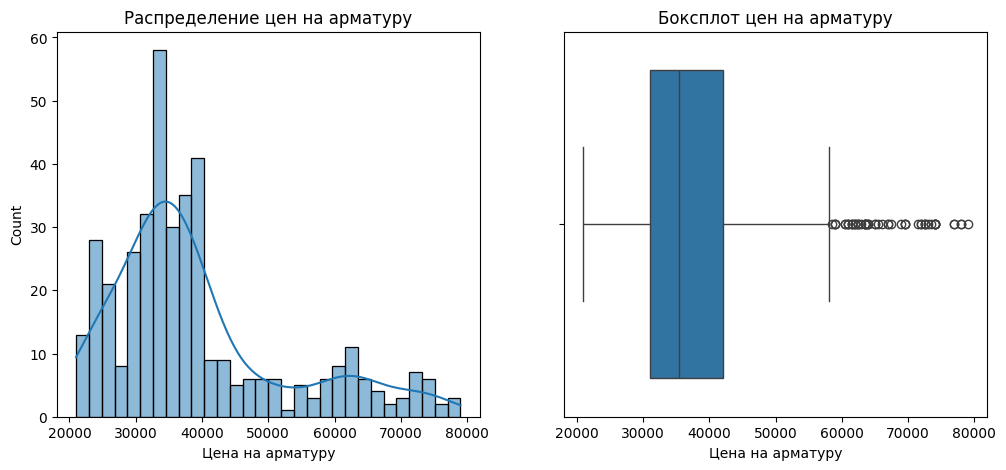

In [10]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")

# Боксплот
plt.subplot(1, 2, 2)
sns.boxplot(x=df_ts["Цена на арматуру"])
plt.title("Боксплот цен на арматуру")

plt.show()

In [11]:
result = adfuller(df_ts["Цена на арматуру"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Ряд нестационарен (не отвергаем H0)


In [12]:
df_ts.head()

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


In [14]:
# Нормализация данных (LSTM лучше работает с масштабированными данными)
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру"] = scaler.fit_transform(df_ts[["Цена на арматуру"]])

# Разделение на тренировочный и тестовый наборы
train_size = int(len(df_ts) * 0.8)  # 80% на обучение, 20% на тест
train, test = df_ts.iloc[:train_size], df_ts.iloc[train_size:]


In [21]:
# 4. Создание окон временного ряда
import numpy as np

def create_sequences(df_ts, seq_length):
    X, y = [], []
    for i in range(len(df_ts) - seq_length):
        X.append(df_ts.iloc[i:i+seq_length].values)  # Используем .iloc для работы с DataFrame
        y.append(df_ts.iloc[i+seq_length].values)  # Доступ к следующему значению
    return np.array(X), np.array(y)

# Гиперпараметр: длина окна (количество предыдущих дней, используемых для предсказания)
seq_length = 20

# Проверяем, что столбец существует в DataFrame
if "Цена на арматуру" not in df_ts.columns:
    raise KeyError("Столбец 'Цена на арматуру' не найден в df_ts!")

# Выбираем нужный столбец и передаем в функцию
X_train, y_train = create_sequences(df_ts[["Цена на арматуру"]], seq_length)
X_test, y_test = create_sequences(df_ts[["Цена на арматуру"]], seq_length)

# Изменение формы для LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [22]:
# 5. Создание и обучение LSTM-модели

# Построение модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse")

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0605 - val_loss: 0.0119
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0115 - val_loss: 0.0089
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0094 - val_loss: 0.0084
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0134 - val_loss: 0.0077
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0070 - val_l

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MAE: 0.03
RMSE: 0.04


ValueError: x and y must have same first dimension, but have shapes (60,) and (380, 1)

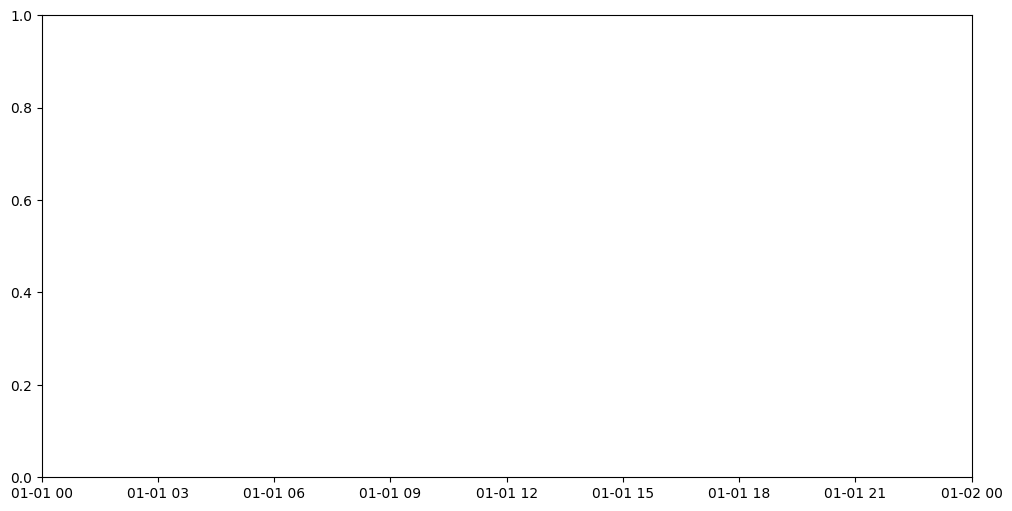

In [24]:
# -6. Оценка качества модели

# Предсказания модели
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Оценка ошибок
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(df["dt"].iloc[train_size + seq_length:], y_test_inv, label="Фактические цены")
plt.plot(df["dt"].iloc[train_size + seq_length:], y_pred_inv, label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.legend()
plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 20, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0238 - val_loss: 0.0701
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0099 - val_loss: 0.0289
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0066 - val_loss: 0.0228
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0047 - val_loss: 0.0311
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0052 - val_loss: 0.0206
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0053 - val_loss: 0.0195
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0041 - val_loss: 0.0201
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0045 - val_loss: 0.0187
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0029 - val_loss: 0.0167
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0034 - val_loss: 0.0160
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0027 - val_loss: 0.0139
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.

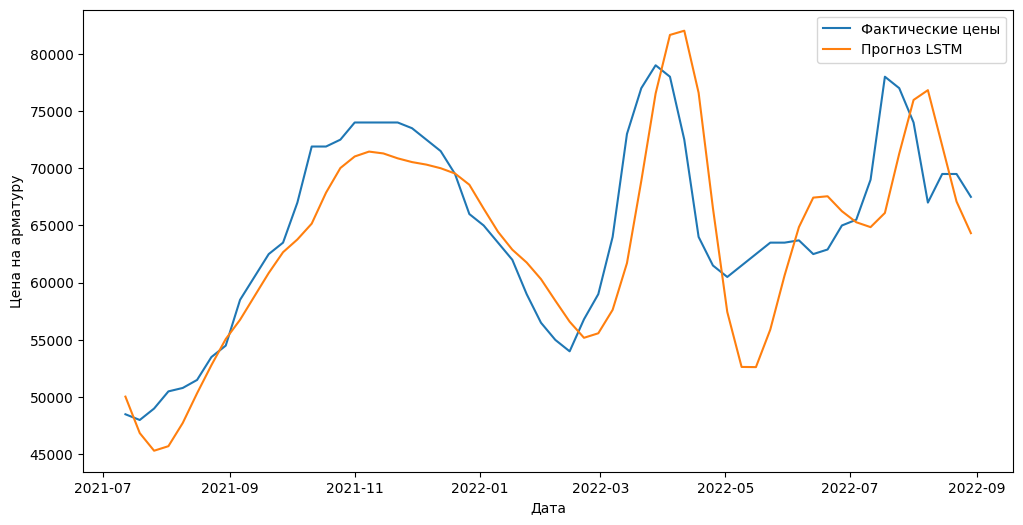

In [28]:


# *2. Проверка данных*
if "Цена на арматуру" not in df_ts.columns:
    raise KeyError("Столбец 'Цена на арматуру' не найден в df_ts!")

# *3. Нормализация данных*
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру"] = scaler.fit_transform(df_ts[["Цена на арматуру"]])


# *7. Создание модели LSTM*
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

# *8. Обучение модели*
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# *9. Предсказание*
y_pred = model.predict(X_test)

# *10. Обратное масштабирование предсказаний*
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# *11. Оценка модели*
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# *12. Визуализация предсказаний*
min_len = min(len(df_ts["dt"].iloc[train_size + seq_length:]), len(y_test_inv))

plt.figure(figsize=(12, 6))
plt.plot(df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + min_len],
         y_test_inv[:min_len], label="Фактические цены")
plt.plot(df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + min_len],
         y_pred_inv[:min_len], label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.legend()
plt.show()